In [1]:
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

warnings.filterwarnings('ignore')

In [2]:
# Loading preprocessed data
data = pd.read_csv('cleaned_data.csv',index_col=0)
data_val = pd.read_csv('cleaned_data_validation.csv',index_col=0)

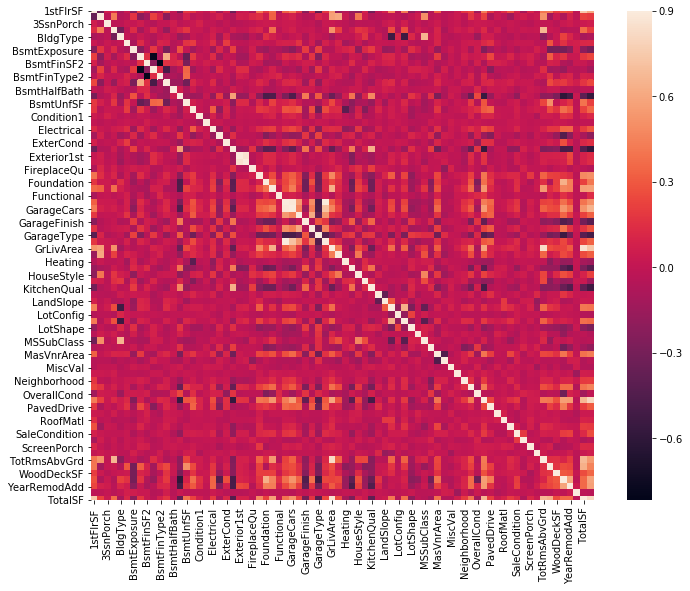

In [6]:
#Correlation map to see how features are correlated with SalePrice
corrmat = data.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [8]:
X = data.drop(['SalePrice'],axis=1)
y = data['SalePrice']

X.shape, y.shape

((1456, 75), (1456,))

### Feature Selection/ Elimination

In [9]:
from sklearn.feature_selection import VarianceThreshold

In [14]:
# Constant and Quasi feature removal
quasi_constant_filter = VarianceThreshold(threshold=0.01)
quasi_constant_filter.fit(X)
print(quasi_constant_filter.get_support().sum())


selectedColumnIndexes = [i for i, val in enumerate(quasi_constant_filter.get_support()) if val]
selecedColumns = X.columns[selectedColumnIndexes]

X_train_quasi_filter = pd.DataFrame(quasi_constant_filter.transform(X),columns=selecedColumns)

print(X.shape,X_train_quasi_filter.shape)

71
(1456, 75) (1456, 71)


In [15]:
corrmat = X_train_quasi_filter.corr()

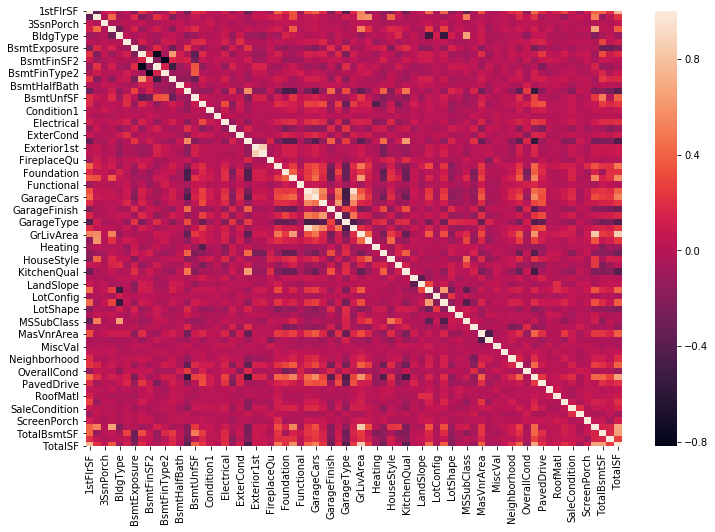

In [16]:
plt.figure(figsize=(12,8))
sns.heatmap(corrmat)

In [17]:
def get_correlation(data, threshold):
    corr_col = set()
    corrmat = data.corr()
    for i in range(len(corrmat.columns)):
        for j in range(i):
            if abs(corrmat.iloc[i,j]) > threshold:
                colname = corrmat.columns[i]
                corr_col.add(colname)
    return corr_col

corr_features = get_correlation(X_train_quasi_filter,0.85)

In [18]:
corr_features

{'Exterior2nd', 'GarageCars', 'GarageYrBlt', 'TotalSF'}

In [19]:
X_train_uncorr = X_train_quasi_filter.drop(labels=corr_features,axis=1)

print(X.shape,X_train_quasi_filter.shape,X_train_uncorr.shape)

(1456, 75) (1456, 71) (1456, 67)


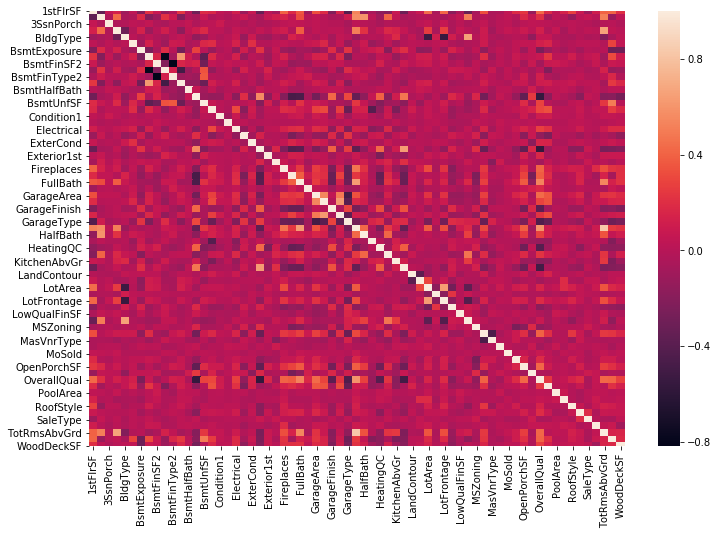

In [20]:
corrmat = X_train_uncorr.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corrmat)

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

In [29]:
X_train,X_test,y_train,y_test = train_test_split(X_train_uncorr,y,test_size=0.2,random_state=0)

In [37]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor

In [34]:
#Validation function
n_folds = 5
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [35]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [36]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1275 (0.0051)

ElasticNet score: 0.1275 (0.0052)

Kernel Ridge score: 0.1529 (0.0039)

Gradient Boosting score: 0.1257 (0.0092)

Xgboost score: 0.1255 (0.0075)



### Additional things can be applied

* Apply Grid search
* Predict with Actual test data set
* Using ensemble method
* reverse value of SalesPrices to get Actual value

## Thanks....Happy Learning!!!